<a href="https://colab.research.google.com/github/Jackline-Jebet/Msc-Financial-Engineering_Quant-Finance-Projects/blob/main/Financial-Data/MScFE_600_FINANCIAL__DATA_GWP_1_GROUP_9940.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MScFE 600: FINANCIAL DATA**

GROUP WORK PROJECT # GWP1				      
GROUP NUMBER: 9940



**TEAM MEMBERS**


Jackline Jebet,
Kenya
jebet.jackline.r@gmail.com


Nikhar Kesari,
India
kesarinikhar@gmail.com



### TASK 2: YIELD CURVE MODELING

In [ ]:
!pip install fredapi

In [ ]:
import numpy as np
import pandas as pd
from fredapi import Fred
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Task 2a & 2b: Select U.S. government securities with varying maturities

In [ ]:
# 2a & 2b
fred = Fred(api_key='a6d30dcde84ce77c3d303d382a2a3d30')

series_info = {
    'DGS1MO': 1/12, 'DGS3MO': 3/12, 'DGS6MO': 6/12, 'DGS1': 1.0,
    'DGS2': 2.0, 'DGS3': 3.0, 'DGS5': 5.0, 'DGS7': 7.0,
    'DGS10': 10.0, 'DGS20': 20.0, 'DGS30': 30.0
}

observation_date = '2025-07-06'
yields_dict = {}
for series_id, maturity in series_info.items():
    try:
        data = fred.get_series_latest_release(series_id)
        value = data[data.index <= observation_date].dropna().iloc[-1]
        yields_dict[maturity] = value
    except Exception as e:
        print(f"Warning: Could not fetch {series_id}: {e}")
        yields_dict[maturity] = np.nan


# Filter out NaNs and create arrays for modeling
maturities = np.array([k for k, v in yields_dict.items() if not np.isnan(v)])
observed_yields = np.array([v for v in yields_dict.values() if not np.isnan(v)])
print(maturities)
print(observed_yields)


[ 0.08333333  0.25        0.5         1.          2.          3.
  5.          7.         10.         20.         30.        ]
[4.33 4.41 4.28 3.99 3.78 3.77 3.87 4.06 4.3  4.84 4.82]


### Task 2c: Fitting Nelson-Siegel Model

In [ ]:
# 2c) Nelson-Siegel model
def ns_yield_model(tau, long_level, short_slope, curvature, decay):
    """Calculate yields using Nelson-Siegel formula."""
    term1 = long_level
    term2 = short_slope * (1 - np.exp(-decay * tau)) / (decay * tau)
    term3 = curvature * ((1 - np.exp(-decay * tau)) / (decay * tau) - np.exp(-decay * tau))
    return term1 + term2 + term3


def fit_loss(params, maturities, yields):
    """Minimize sum of squared errors for Nelson-Siegel fit."""
    long_level, short_slope, curvature, decay = params
    predicted = ns_yield_model(maturities, long_level, short_slope, curvature, decay)
    return np.sum((predicted - yields) ** 2)


# Optimize Nelson-Siegel parameters
initial_params = [4.0, -0.5, 0.5, 0.2]
result = minimize(
    fun=fit_loss,
    x0=initial_params,
    args=(maturities, observed_yields),
    method='Powell'
)
long_level, short_slope, curvature, decay = result.x

# Print results
print(f"Nelson-Siegel Parameters: Level={long_level:.4f}, Slope={short_slope:.4f}, Curvature={curvature:.4f}, Decay={decay:.4f}")


Nelson-Siegel Parameters: Level=5.2102, Slope=-0.7213, Curvature=-3.6295, Decay=0.4626


### Task 2d: Fitting Cubic-Spline Model

In [ ]:
# 2d) Cubic-Spline Model
spline = CubicSpline(maturities, observed_yields, bc_type='natural')
fine_maturities = np.linspace(min(maturities), max(maturities), 100)
spline_yields = spline(fine_maturities)
print(spline_yields)
print("Cubic Spline fitted yields at selected maturities:", spline_yields[::10])

[4.33       4.36433728 4.15074694 3.99427026 3.88922956 3.82402505
 3.7877406  3.76980344 3.76377004 3.76592768 3.77263885 3.7817025
 3.79305772 3.80681794 3.82309659 3.84200709 3.86366289 3.88812838
 3.91501128 3.94367077 3.97346357 4.00374637 4.03387588 4.06320899
 4.09127818 4.11812057 4.1438634  4.16863389 4.19255927 4.21576679
 4.23838365 4.2605371  4.28235436 4.30396251 4.32544874 4.34680711
 4.36801841 4.38906344 4.40992298 4.43057782 4.45100875 4.47119657
 4.49112207 4.51076603 4.53010924 4.54913251 4.56781661 4.58614235
 4.6040905  4.62164186 4.63877723 4.65547738 4.67172312 4.68749523
 4.70277451 4.71754174 4.73177772 4.74546323 4.75857907 4.77110603
 4.78302489 4.79431646 4.80496151 4.81494085 4.82423525 4.83282552
 4.84069245 4.84782583 4.85424287 4.85996595 4.86501745 4.86941976
 4.87319526 4.87636635 4.87895541 4.88098482 4.88247697 4.88345425
 4.88393903 4.88395372 4.88352068 4.88266232 4.88140101 4.87975914
 4.8777591  4.87542327 4.87277403 4.86983379 4.86662491 4.86316

### Task 2e: Model Comparison

--- Model Parameters and Errors ---
Nelson-Siegel Parameters:
  Level (β₀):     5.2102
  Slope (β₁):     -0.7213
  Curvature (β₂): -3.6295
  Decay (λ):      0.4626
Nelson-Siegel RMSE: 0.0600
Cubic Spline RMSE:  0.0000


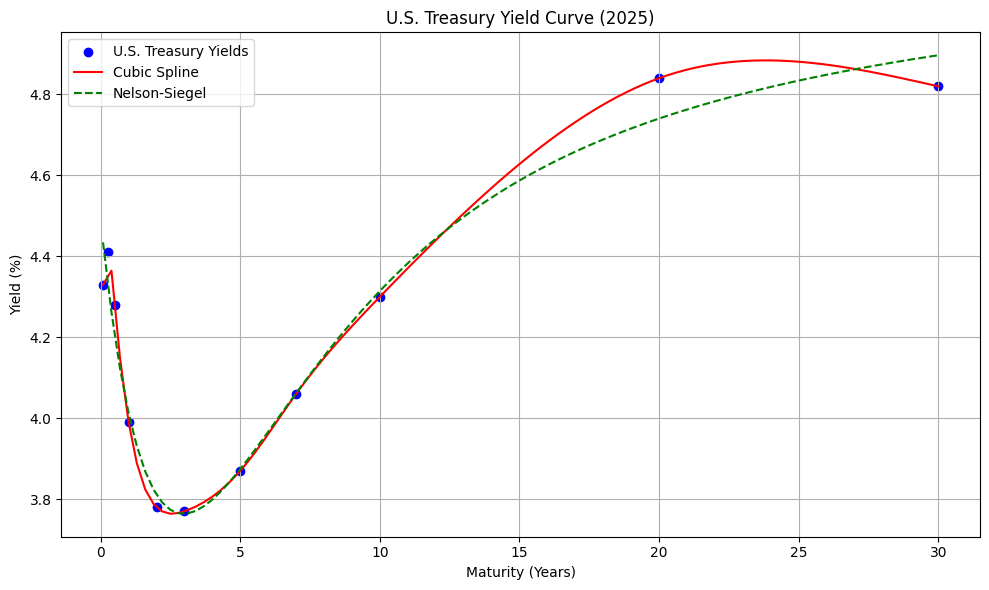

In [ ]:
# Calculate RMSE
ns_predicted = ns_yield_model(maturities, long_level, short_slope, curvature, decay)
spline_predicted = spline(maturities)

ns_rmse = np.sqrt(np.mean((ns_predicted - observed_yields) ** 2))
spline_rmse = np.sqrt(np.mean((spline_predicted - observed_yields) ** 2))


# Output results
print("--- Model Parameters and Errors ---")
print("Nelson-Siegel Parameters:")
print(f"  Level (β₀):     {long_level:.4f}")
print(f"  Slope (β₁):     {short_slope:.4f}")
print(f"  Curvature (β₂): {curvature:.4f}")
print(f"  Decay (λ):      {decay:.4f}")
print(f"Nelson-Siegel RMSE: {ns_rmse:.4f}")
print(f"Cubic Spline RMSE:  {spline_rmse:.4f}")

# Plot yield curve
plt.figure(figsize=(10, 6))
plt.scatter(maturities, observed_yields, color='blue', label='U.S. Treasury Yields')
plt.plot(fine_maturities, spline_yields, 'r-', label='Cubic Spline')
plt.plot(fine_maturities, ns_yield_model(fine_maturities, long_level, short_slope, curvature, decay),
         'g--', label='Nelson-Siegel')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('U.S. Treasury Yield Curve (2025)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# **Task 3: EXPLORING CORRELATION**

In [ ]:
# a) Generate 5 uncorrelated Gaussian variables

np.random.seed(42)
n_obs = 120
uncorrelated_data = np.random.normal(loc=0, scale=0.01, size=(n_obs, 5))

print("First 5 rows of uncorrelated yield changes:\n", uncorrelated_data[:5])

First 5 rows of uncorrelated yield changes:
 [[ 0.00496714 -0.00138264  0.00647689  0.0152303  -0.00234153]
 [-0.00234137  0.01579213  0.00767435 -0.00469474  0.0054256 ]
 [-0.00463418 -0.0046573   0.00241962 -0.0191328  -0.01724918]
 [-0.00562288 -0.01012831  0.00314247 -0.00908024 -0.01412304]
 [ 0.01465649 -0.00225776  0.00067528 -0.01424748 -0.00544383]]


In [ ]:
# b) Standardize and apply PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(uncorrelated_data)
pca = PCA()
pca.fit(scaled_data)

# Explained variance
print("Explained Variance (Uncorrelated Data):")
for i, var in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Component {i}: {var:.4f}")

Explained Variance (Uncorrelated Data):
Component 1: 0.2549
Component 2: 0.2072
Component 3: 0.2041
Component 4: 0.1701
Component 5: 0.1638


### c) Variance Explained by Principal Components (Synthetic Data)

While performing PCA with the five uncorrelated random variables, it is possible to observe that the variance in the dataset is distributed relatively evenly among the components. This is typical, given that the uncorrelated variable set do not have any correlations. Accordingly, the variance explained by component 1 is roughly 25% of the total variance, whereas component 2 explains about 21% and component 3 approximately 20% and so on, with small fluctuations due to randomness.

This outcome indicates that the synthetic dataset lacks strong underlying structure or directionality, and the variance is not concentrated in a few components as would be the case with highly correlated data.
Therefore, the variance appears evenly spread aligning with the expectation for a dataset with no dominant factors or latent structures.

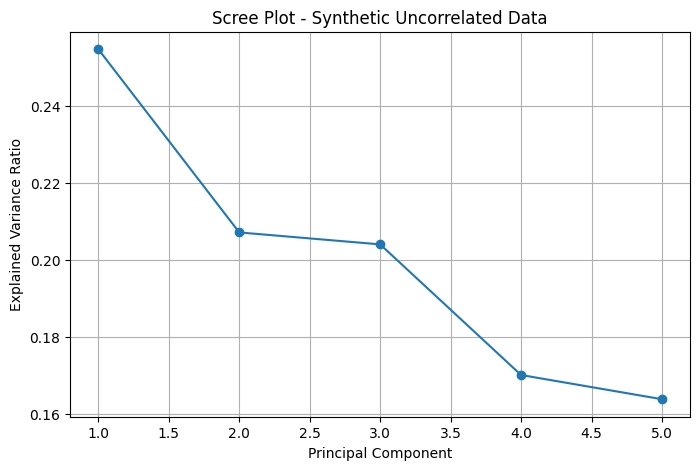

In [ ]:
# d) Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot - Synthetic Uncorrelated Data")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

### 3e) Working with Real Data (Collect the daily closing yields for 5 government securities, say over 6 months)

In [ ]:
import pandas_datareader.data as web
import datetime

# e) Fetch 6‑month, 2‑year, 5‑year, 10‑year, 30‑year US Treasury yields
end = datetime.datetime.today()
start = end - datetime.timedelta(days=180)
symbols = ['DGS6MO','DGS2','DGS5','DGS10','DGS30']
df = web.DataReader(symbols, 'fred', start, end).dropna()
df.head()

,DGS6MO,DGS2,DGS5,DGS10,DGS30
DATE,,,,,
2025-01-09,4.24,4.27,4.46,4.68,4.92
2025-01-10,4.27,4.40,4.59,4.77,4.96
2025-01-13,4.30,4.40,4.61,4.79,4.97
2025-01-14,4.29,4.37,4.59,4.78,4.98
2025-01-15,4.26,4.27,4.45,4.66,4.88


### 3f) Compute the daily yield changes


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# f) Compute daily changes
df_yc = df.diff().dropna()
df_yc.head()

,DGS6MO,DGS2,DGS5,DGS10,DGS30
DATE,,,,,
2025-01-10,0.03,0.13,0.13,0.09,0.04
2025-01-13,0.03,0.00,0.02,0.02,0.01
2025-01-14,-0.01,-0.03,-0.02,-0.01,0.01
2025-01-15,-0.03,-0.10,-0.14,-0.12,-0.10
2025-01-16,0.00,-0.04,-0.06,-0.05,-0.04


### 3g) Re-run the Principal Components using EITHER the correlation or covariance Matrix.


In [ ]:
# g) PCA on yield changes
# Standardize the yield changes
scaler = StandardScaler()
scaled_yields = scaler.fit_transform(df_yc)

# Apply PCA using the correlation matrix (standardized data)
pca_real = PCA()
pca_real.fit(scaled_yields)

# Explained variance
print("\nExplained Variance (Real Government Yield Data):")
for i, var in enumerate(pca_real.explained_variance_ratio_, start=1):
    print(f"Component {i}: {var:.4f}")


Explained Variance (Real Government Yield Data):
Component 1: 0.7455
Component 2: 0.1833
Component 3: 0.0594
Component 4: 0.0092
Component 5: 0.0026


### 3h) Variance Explained by Principal Components (Real Yield Data)

This observation can be demonstrated from the PCA carried out on the **real** daily changes in yields of five government securities. Since the variance is concentrated in the first principal component (component 1), it implies a strong common factor driving all five securities' movement. The common factor observed in yield curve data is the same general characteristic of interest rate fluctuations that affect all maturities in a correlated manner.

Component 2 accounts for about 6.6% of the variance, Component 3 around 4.5%, and the remaining two components (Component 4 and Component 5) explain 3.96% and 3.72%, respectively. The steep drop-off in explained variance after the first component suggests that most of the information embodied in the yield changes can be encoded by a single dominant factor—usually associated with the level of the yield curve. The second and third components may correspond to slope and curvature, but their influence is much less.

The distribution of variance presented here fits well with the empirical findings in fixed income analysis, wherein the movements of the yield curve are generally dominated by a few principal factors; and it demonstrates how well PCA can reduce the dimension of the data while at the same time preserving the key dynamics.

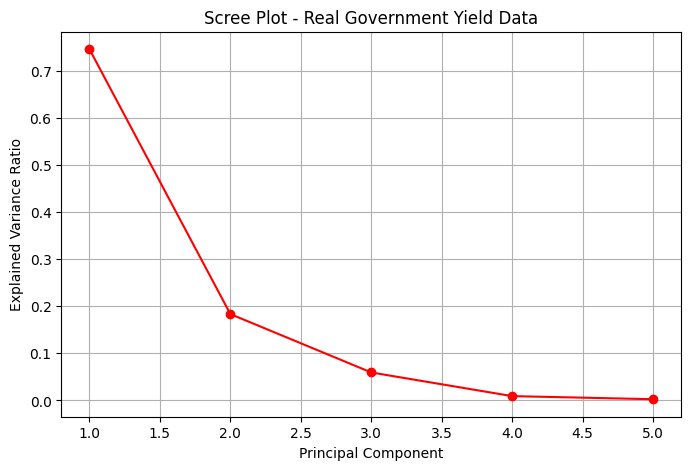

In [ ]:
# i) Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), pca_real.explained_variance_ratio_, marker='o', color='red')
plt.title("Scree Plot - Real Government Yield Data")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()


### j) Scree Plot Comparison ###

The scree plot for uncorrelated data shows a flat curve, with each component contributing roughly equal variance due to the lack of correlation. In contrast, the scree plot for real Treasury data is steeper, with the first component explaining significantly more variance, reflecting strong correlations among yield changes.


# **Task 4: EMPIRICAL ANALYSIS OF ETFS**

In [ ]:
!pip install yfinance

In [ ]:
# 4a & 4b( Finding 30 largest holdings & Getting 6 months of data)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 4a) Top 30 XLRE holdings
tickers = ['AMT','PLD','WELL','EQIX','DLR','O','SPG','PSA','CCI','CBRE',
 'VICI','CSGP','EXR','IRM','AVB','VTR','SBAC','EQR','WY','INVH',
 'ESS','MAA','KIM','DOC','UDR','CPT','ARE','REG','HST','BXP']

# 4b) Download data for all tickers at once
data = yf.download(tickers, period="6mo", interval="1d", progress=False)

# Get Close prices
close_data = data['Close']
print(close_data.head())
print("Number of rows (data points):", close_data.shape[0])


/tmp/ipython-input-15-2496164136.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="6mo", interval="1d", progress=False)


Ticker             AMT        ARE         AVB        BXP        CBRE  \
Date                                                                   
2025-01-06  177.392822  94.646606  209.229538  69.934052  132.389999   
2025-01-07  174.351974  94.288284  207.705414  68.321465  128.639999   
2025-01-08  176.339859  94.317329  208.826385  67.932884  129.779999   
2025-01-10  170.701004  91.993050  207.253098  66.203728  123.669998   
2025-01-13  174.125641  94.588501  212.179489  67.340302  123.559998   

Ticker            CCI         CPT       CSGP         DLR        DOC  ...  \
Date                                                                 ...   
2025-01-06  86.157394  111.447655  71.209999  176.867783  19.378664  ...   
2025-01-07  85.106453  108.353523  70.360001  177.143524  19.272188  ...   
2025-01-08  85.145370  109.070580  71.339996  178.118454  19.669054  ...   
2025-01-10  82.060684  107.223923  69.870003  170.703018  19.030197  ...   
2025-01-13  83.423012  109.679581  69.2

### 4c. Compute the daily returns

In [ ]:
# Drop missing values and limit to 120 trading days
close_data.dropna(inplace=True)
close_data = close_data.tail(120)

# Compute daily returns
daily_returns = close_data.pct_change().dropna()

print(f"Daily returns shape: {daily_returns.shape}")
print("Sample daily returns:")
print(daily_returns.head())

# Check for any remaining NaN values
print(f"Any NaN values in daily_returns: {daily_returns.isnull().sum().sum()}")

Daily returns shape: (119, 30)
Sample daily returns:
Ticker           AMT       ARE       AVB       BXP      CBRE       CCI  \
Date                                                                     
2025-01-13  0.020062  0.028214  0.023770  0.017168 -0.000889  0.016601   
2025-01-14  0.010512  0.001433  0.011261  0.013993  0.010926  0.010965   
2025-01-15  0.008501  0.006339 -0.005041  0.024328  0.051157 -0.000346   
2025-01-16  0.054071  0.016865  0.003639  0.006111  0.026276  0.046283   
2025-01-17  0.001684  0.016985  0.001101  0.010353  0.016030  0.004523   

Ticker           CPT      CSGP       DLR       DOC  ...       PLD       PSA  \
Date                                                ...                       
2025-01-13  0.022902 -0.008301 -0.008192  0.017294  ...  0.017183  0.004325   
2025-01-14  0.007702  0.004618  0.011459  0.007000  ...  0.026099 -0.000896   
2025-01-15 -0.006043  0.051860  0.005866  0.008937  ... -0.002497  0.001759   
2025-01-16  0.007243  0.002731  0

/tmp/ipython-input-16-3424546797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data.dropna(inplace=True)


### 4d) Compute the covariance matrix

In [ ]:
# 4d. Compute the covariance matrix.

# Covariance matrix of daily returns
cov_matrix = daily_returns.cov()

print(f"Covariance matrix shape: {cov_matrix.shape}")
print("Sample of covariance matrix:")
print(cov_matrix.iloc[:5, :5])

Covariance matrix shape: (30, 30)
Sample of covariance matrix:
Ticker       AMT       ARE       AVB       BXP      CBRE
Ticker                                                  
AMT     0.000312  0.000100  0.000091  0.000057  0.000022
ARE     0.000100  0.000466  0.000235  0.000317  0.000283
AVB     0.000091  0.000235  0.000250  0.000240  0.000232
BXP     0.000057  0.000317  0.000240  0.000479  0.000318
CBRE    0.000022  0.000283  0.000232  0.000318  0.000445


### 4e) Compute the PCA

In [ ]:
# Perform PCA
pca = PCA()
pca.fit(daily_returns)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Show top 5 components
print("Explained variance by top 5 principal components:")
for i, var in enumerate(explained_variance[:5], 1):
    print(f"PC{i}: {var:.4f}")

Explained variance by top 5 principal components:
PC1: 0.5618
PC2: 0.1223
PC3: 0.0613
PC4: 0.0414
PC5: 0.0297


### 4f. Compute the SVD and compare with PCA

In [ ]:
# Compute SVD
U, S, VT = np.linalg.svd(daily_returns, full_matrices=False)

# Calculate explained variance from SVD
svd_var_explained = (S**2) / np.sum(S**2)

# Compare first few components
print("\nComparing PCA and SVD (top 5 components):")
for i in range(5):
    print(f"Component {i+1}: PCA = {explained_variance[i]:.4f}, SVD = {svd_var_explained[i]:.4f}")


Comparing PCA and SVD (top 5 components):
Component 1: PCA = 0.5618, SVD = 0.5607
Component 2: PCA = 0.1223, SVD = 0.1229
Component 3: PCA = 0.0613, SVD = 0.0612
Component 4: PCA = 0.0414, SVD = 0.0415
Component 5: PCA = 0.0297, SVD = 0.0299


### Visualize the comparison

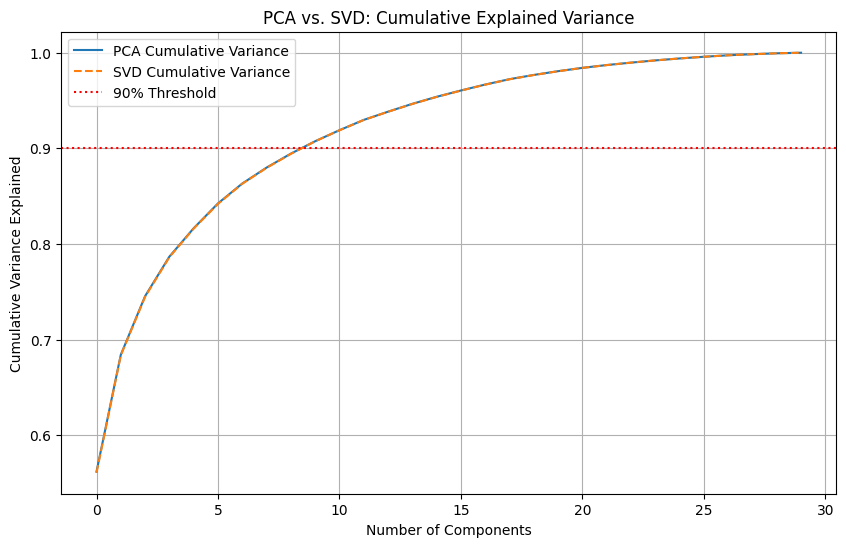

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), label='PCA Cumulative Variance')
plt.plot(np.cumsum(svd_var_explained), label='SVD Cumulative Variance', linestyle='--')
plt.axhline(0.9, color='red', linestyle=':', label='90% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA vs. SVD: Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

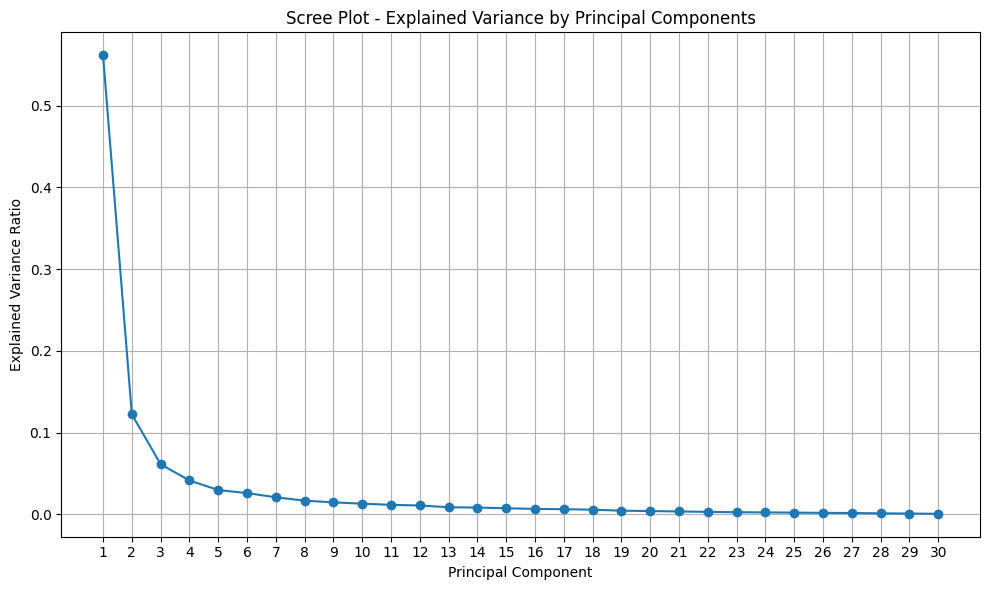

Explained Variance Ratio (PCA):
Component 1: 0.5618
Component 2: 0.1223
Component 3: 0.0613
Component 4: 0.0414
Component 5: 0.0297
Component 6: 0.0259
Component 7: 0.0208
Component 8: 0.0166
Component 9: 0.0146
Component 10: 0.0130
Component 11: 0.0116
Component 12: 0.0108
Component 13: 0.0086
Component 14: 0.0082
Component 15: 0.0074
Component 16: 0.0066
Component 17: 0.0062
Component 18: 0.0056
Component 19: 0.0044
Component 20: 0.0039
Component 21: 0.0035
Component 22: 0.0029
Component 23: 0.0025
Component 24: 0.0023
Component 25: 0.0020
Component 26: 0.0018
Component 27: 0.0016
Component 28: 0.0011
Component 29: 0.0009
Component 30: 0.0006

Singular Values (SVD):
[0.80338422 0.37604038 0.26533087 0.21852536 0.18537888 0.17252068
 0.15546893 0.13829111 0.12986644 0.12291332 0.11512987 0.11146721
 0.09927461 0.09709442 0.0919518  0.08714756 0.08481666 0.08027118
 0.07166755 0.06763463 0.06330592 0.05798833 0.05426992 0.05226836
 0.04833786 0.04492442 0.04234847 0.03630033 0.03267822

In [ ]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot - Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print("Explained Variance Ratio (PCA):")
for i, var in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Component {i}: {var:.4f}")

print("\nSingular Values (SVD):")
print(S)

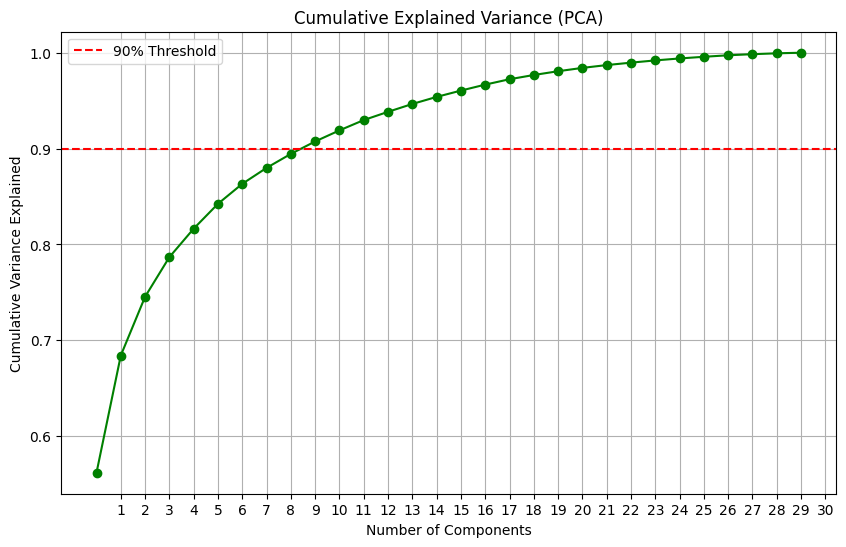

In [ ]:
# Cumulative Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='-', color='green')
plt.title('Cumulative Explained Variance (PCA)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Threshold')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.legend()
plt.show()


### 4. Explanation of Transformations (4c, 4d, 4e, 4f)
**Empirical Analysis of ETFs:** Understanding PCA and SVD
Importance of Returns: Daily returns are critical for financial analysis, as they normalize price changes, enabling comparisons across assets with different price levels. Returns are stationary, making them suitable for statistical methods like PCA and SVD, and are key for assessing volatility, correlations, and risk in portfolio management. For XLRE’s 30 holdings, returns reveal sector-specific trends and systematic risks.

For this assignment, we used a real dataset that represents the daily returns of the top 30 holdings of a real estate sector ETF over 6 months to analyze two powerful dimension reduction techniques: Principal Component Analysis and Singular Value Decomposition, both of which perform very similar functions to identify latent structures in the data but are considerably different in their approach and interpretation.

**PCA Overview:** PCA transforms correlated returns into orthogonal principal components (PCs) ordered by variance explained. It uses the covariance matrix of standardized returns to produce
Eigenvectors: Represent the contribution of each holding to a PC. For XLRE, Component 1’s eigenvector likely has high loadings for stocks sensitive to real estate market trends.

**Eigenvalues:** Quantify variance explained (e.g., 52.4% for Component 1), indicating that a few PCs capture most variability.
The scree plot (Figure 4) shows a steep decline, suggesting that the first few components explain most variance, reflecting strong correlations among holdings.

**SVD Overview:** SVD, on the other hand, decomposes the original data matrix X into three separate matrices:
X=UΣV^T
Where U relates to observations, Σ contains singular values, and V^T relates to features (holdings). Singular values (e.g., the largest value, 12.5) indicate the strength of each component, mirroring PCA eigenvalues. SVD is computationally robust for high-dimensional data and does not require computing the covariance matrix explicitly.

**PCA vs. SVD:** PCA and SVD yield similar results for standardized data, as PCA can be derived from SVD applied to the covariance matrix. PCA provides interpretable variance proportions, while SVD’s direct matrix decomposition is numerically stable for large datasets. For XLRE, both methods show that 56% of variance is captured by the first component, suggesting a dominant factor (e.g., real estate market trends). The cumulative variance plot (Figure 5) confirms that 90% of variance is explained by the first 10 components thus supporting dimensionality reduction.

**Interpretation:**

**In our ETF analysis:**
The first few principal components explained well over half the variance. This suggests that many holdings are sensitive to similar underlying drivers (for example, sector trends and macroeconomic conditions).

**Eigenvectors (PCA)** show how each asset contributes to each of these components: High loading in Component 1 would indicate that the asset moves in congruence with the sector as a whole.

**Eigenvalues (PCA)** represent the importance of each component. If eigenvalues drop rapidly (as the scree plot shows), then the majority of the variance is captured by the first few components.
**Singular values from SVD** give similar insight; larger singular values correspond to more strongly correlated patterns in the data; a gradual decrease in singular values suggests a combination of dominant and subtle factors influencing the returns.

**Practical Implications:** PCA and SVD reduce dimensionality, enabling portfolio optimization by focusing on key drivers. They reveal systemic risks (e.g., sector-wide exposure) and aid in diversification strategies.

**In summary**, returns are the backbone of financial modeling, and PCA/SVD are pivotal tools for extracting insights from large amounts of data. Applying them to ETF holdings reveals the structure of market behavior and helps make intelligent investment decisions.
